## Mounting drive and importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

%cd /content/drive/My Drive/Colab Notebooks/Project/datasets

/content/drive/My Drive/Colab Notebooks/Project/datasets


## Predictive Maintenance

The business challenge presented by this simulated data is to forecast problems created by equipment failures. Hence, the business query is "What is the likelihood that a machine fails due to an equipment failures during the next 'x' days?" The prediction model is developed using a machine learning technique, and the problem is implemented as a multi-class classification problem (many components per machine). Historical data gathered from machines is used to train the model.

The objective of this project is to know the probability of failure of a component of a machine in the near future and thereby achieve the best possible balance of corrective and preventive maintenance.

This method only replaces those components when they are on the verge of failing. The savings come from both prolonging component lifespans (in contrast to preventive maintenance) and reducing unscheduled maintenance (over corrective maintenance). In this way, it is possible to deal with costs related to mechanical failures in advance, acting preventively, saving time and money.

Dataset from Kaggle https://www.kaggle.com/competitions/mpred-datascience-challenge/data

1. Source file details
2. Data Type Details of each file
3. The process of consolidation all datasets into one
4. EDA


Preprocessing and EDA

Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Data Manipulation
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier as xgb



Failure history, machine conditions, repair history, usage history are time series indicated by the timestamp of data collection. Machine and operator specific features, are more static, since they describe the technical specifications of machines or operator’s properties.

In [4]:
# Loading the datasets

# telemetry_url = 'https://media.githubusercontent.com/media/SoumyaPrabash/SQL-Server-R-Services-Samples/master/PredictiveMaintenanceModelingGuide/Data/telemetry.csv'
# errors_url = 'https://media.githubusercontent.com/media/SoumyaPrabash/SQL-Server-R-Services-Samples/master/PredictiveMaintenanceModelingGuide/Data/errors.csv'
# maint_url = 'https://media.githubusercontent.com/media/SoumyaPrabash/SQL-Server-R-Services-Samples/master/PredictiveMaintenanceModelingGuide/Data/maint.csv'
# failures_url = 'https://media.githubusercontent.com/media/SoumyaPrabash/SQL-Server-R-Services-Samples/master/PredictiveMaintenanceModelingGuide/Data/failures.csv'
# machines_url = 'https://media.githubusercontent.com/media/SoumyaPrabash/SQL-Server-R-Services-Samples/master/PredictiveMaintenanceModelingGuide/Data/machines.csv'

telemetry = pd.read_csv('PdM_telemetry.csv',error_bad_lines=False)
errors = pd.read_csv('PdM_errors.csv', error_bad_lines=False)
maint = pd.read_csv('PdM_maint.csv', error_bad_lines=False)
failures = pd.read_csv('PdM_failures.csv', error_bad_lines=False)
machines = pd.read_csv('PdM_machines.csv', error_bad_lines=False)

<ipython-input-4-c50edb711461>:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  telemetry = pd.read_csv('PdM_telemetry.csv',error_bad_lines=False)
b'Skipping line 92490: expected 6 fields, saw 9\n'
<ipython-input-4-c50edb711461>:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  errors = pd.read_csv('PdM_errors.csv', error_bad_lines=False)
<ipython-input-4-c50edb711461>:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  maint = pd.read_csv('PdM_maint.csv', error_bad_lines=False)
<ipython-input-4-c50edb711461>:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  failures = pd.read_csv('PdM_failures.csv', error_bad_line

## Telemetry Dataset

In [ ]:
telemetry

In [5]:
# Changing datatype of datetime from object to datetime
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [ ]:
telemetry[['volt','rotate','pressure','vibration']].plot(figsize=(30,8))

In [ ]:
tel_dup = telemetry.duplicated(subset=['datetime','machineID'])
telemetry[tel_dup]

In [6]:
telemetry = telemetry.drop_duplicates(subset=['datetime','machineID'])

In [ ]:
telemetry

In [ ]:
telemetry.describe().apply(lambda s: s.apply('{0:.5f}'.format))

In [ ]:
errors

In [7]:
errors['datetime'] = pd.to_datetime(errors['datetime'])
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [8]:
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']


In [9]:
error_count = error_count.groupby(["machineID", "datetime"]).sum().reset_index()
# error_count.head()

In [ ]:
error_count[['error1','error2','error3','error4','error5']].plot(figsize=(30,8))

In [ ]:
error_count_dup = error_count.duplicated()
error_count_dup
# error_count[error_count_dup]

In [10]:
error_count=error_count.drop_duplicates(subset=['datetime','machineID'])
error_count

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
...,...,...,...,...,...,...,...
3611,100,2015-11-12 01:00:00,1,0,0,0,0
3612,100,2015-11-21 08:00:00,0,1,0,0,0
3613,100,2015-12-04 02:00:00,1,0,0,0,0
3614,100,2015-12-08 06:00:00,0,1,1,0,0


In [ ]:
failures

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [11]:
failures['datetime'] = pd.to_datetime(failures['datetime'])
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [12]:
failure_comp = pd.get_dummies(failures)
failure_comp.columns = ["datetime", "machineID", "comp1_fail", "comp2_fail", "comp3_fail", "comp4_fail"]
# failure_comp.head()

In [13]:
failure_comp = failure_comp.groupby(["machineID", "datetime"]).sum().reset_index()
# failure_comp.head()

In [14]:
failure_comp=failure_comp.drop_duplicates(subset=['datetime','machineID'])

In [ ]:
failure_comp

In [ ]:
# failure_comp_dup = failure_comp.duplicated()
# failure_comp_dup

In [ ]:
# failures.loc[failures['datetime']=='2015-04-05 06:00:00']

In [ ]:
maint

In [15]:
maint['datetime'] = pd.to_datetime(maint['datetime'])
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [16]:
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ["datetime", "machineID", "comp1_replaced", "comp2_replaced", "comp3_replaced", "comp4_replaced"]
# comp_rep.head()

In [17]:
comp_rep = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()
# comp_rep.head()

In [18]:
comp_rep=comp_rep.drop_duplicates(subset=['datetime','machineID'])

In [ ]:
comp_rep

In [19]:
#  Resampling the time data of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]
for col in fields:
  temp.append(pd.pivot_table(telemetry,
                              index="datetime",
                              columns="machineID",
                              values=col).resample("3H", closed="left", label="right").mean().unstack())
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00    170.028993
           2015-01-01 12:00:00    164.192565
           2015-01-01 15:00:00    168.134445
           2015-01-01 18:00:00    165.514453
           2015-01-01 21:00:00    168.809347
dtype: float64

In [20]:
telemetry_mean_3h = pd.concat(temp, axis=1) #combining.
telemetry_mean_3h.columns = [col + "mean_3h" for col in fields] # assigning column names.
telemetry_mean_3h.reset_index(inplace=True) # 
telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [21]:
# Calculating standard deviation as above
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").std().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00     6.721032
           2015-01-01 12:00:00     7.596570
           2015-01-01 15:00:00    10.124584
           2015-01-01 18:00:00     4.673269
           2015-01-01 21:00:00    14.752132
dtype: float64

In [23]:
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + "sd_3h" for i in fields]
telemetry_sd_3h.reset_index(inplace=True)
telemetry_sd_3h.head()

,machineID,datetime,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2015-01-01 09:00:00,NaN,NaN,NaN,NaN
1,1,2015-01-01 12:00:00,NaN,NaN,NaN,NaN
2,1,2015-01-01 15:00:00,NaN,NaN,NaN,NaN
3,1,2015-01-01 18:00:00,NaN,NaN,NaN,NaN
4,1,2015-01-01 21:00:00,NaN,NaN,NaN,NaN


In [22]:
# Calculating mean over a 24 hour duration
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).mean().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00   NaN
           2015-01-01 12:00:00   NaN
           2015-01-01 15:00:00   NaN
           2015-01-01 18:00:00   NaN
           2015-01-01 21:00:00   NaN
dtype: float64

In [24]:
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + "mean_24h" for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
# Removing the first 23 null values
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h["voltmean_24h"].isnull()]

In [25]:
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).std().resample("3H", closed="left", label="right").first().unstack(level=-1)
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00   NaN
           2015-01-01 12:00:00   NaN
           2015-01-01 15:00:00   NaN
           2015-01-01 18:00:00   NaN
           2015-01-01 21:00:00   NaN
dtype: float64

In [26]:
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + "sd_24h" for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h["voltsd_24h"].isnull()]

In [27]:
# Combining the features created
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_sd_3h.iloc[:, 2:6],
    telemetry_mean_24h.iloc[:, 2:6],
    telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,169.733809,445.179865,96.797113,40.385160,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,170.614862,446.364859,96.849785,39.736826,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,169.893965,447.009407,97.715600,39.498374,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,171.243444,444.233563,96.666060,40.229370,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,170.792486,448.440437,95.766838,40.055214,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069


In [28]:

error_count_grouped = error_count.groupby(["machineID", "datetime"]).sum().reset_index()

In [29]:
error_count= telemetry[["datetime", "machineID"]].merge(
    error_count_grouped,
    on=["machineID", "datetime"],
    how="left"
).fillna(0.0)

error_count.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [30]:
# Resampling errors same like telemetry features
temp = []
fields = [
    "error%d" % i
    for i in range(1,6)
]

temp = [
    pd.pivot_table(
        error_count,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).sum().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head(10)

machineID  datetime           
1          2015-01-01 09:00:00    NaN
           2015-01-01 12:00:00    NaN
           2015-01-01 15:00:00    NaN
           2015-01-01 18:00:00    NaN
           2015-01-01 21:00:00    NaN
           2015-01-02 00:00:00    NaN
           2015-01-02 03:00:00    NaN
           2015-01-02 06:00:00    0.0
           2015-01-02 09:00:00    0.0
           2015-01-02 12:00:00    0.0
dtype: float64

In [31]:
error_count_total = pd.concat(temp, axis=1)
error_count_total.columns = [i + "count" for i in fields]
error_count_total.reset_index(inplace=True)
error_count_total = error_count_total.dropna()
error_count_total.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [ ]:

# telemetry1['volt_rolling_mean_24h'] = telemetry1['volt'].rolling(window=8).mean()

# telemetry1['volt_rolling_std_24h'] = telemetry1['volt'].rolling(window=8).std()


# telemetry1['rotate_rolling_mean_24h'] = telemetry1['rotate'].rolling(window=8).mean()


# telemetry1['rotate_rolling_std_24h'] = telemetry1['rotate'].rolling(window=8).std()


# telemetry1['pressure_rolling_mean_24h'] = telemetry1['pressure'].rolling(window=8).mean()

# telemetry1['pressure_rolling_std_24h'] = telemetry1['pressure'].rolling(window=8).std()

# telemetry1['vibration_rolling_mean_24h'] = telemetry1['vibration'].rolling(window=8).mean()

# telemetry1['vibration_rolling_std_24h'] = telemetry1['vibration'].rolling(window=8).std()


In [ ]:
# telemetry1=telemetry1.drop(['volt','rotate','pressure','vibration'],axis=1)
# telemetry1=telemetry1.fillna(method='bfill')
# telemetry1=telemetry1.reset_index()
# telemetry1

In [32]:
df = pd.merge(telemetry_feat,error_count_total,on=['datetime','machineID'],how='left')
df

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,169.733809,445.179865,96.797113,40.385160,...,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,170.614862,446.364859,96.849785,39.736826,...,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,169.893965,447.009407,97.715600,39.498374,...,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,171.243444,444.233563,96.666060,40.229370,...,40.229370,13.299281,41.346121,8.731229,5.687944,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,170.792486,448.440437,95.766838,40.055214,...,40.055214,13.954518,43.490234,8.061653,5.898069,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,100,2015-12-31 21:00:00,166.078945,424.431184,98.344409,30.907459,171.547643,452.351565,101.789714,39.184285,...,39.184285,16.429023,62.147934,7.475540,5.448962,0.0,0.0,0.0,0.0,0.0
291396,100,2016-01-01 00:00:00,158.327984,504.056262,108.055441,40.109705,168.806645,459.502212,100.919285,38.150193,...,38.150193,17.019808,64.730136,8.961444,5.833191,0.0,0.0,0.0,0.0,0.0
291397,100,2016-01-01 03:00:00,170.306956,438.653616,102.346227,47.481232,169.011763,465.923073,101.568092,39.456302,...,39.456302,17.096392,64.718132,9.420879,5.738756,0.0,0.0,0.0,0.0,0.0
291398,100,2016-01-01 06:00:00,182.525427,435.932056,98.798172,42.757630,172.838745,461.095362,101.396728,39.964090,...,39.964090,15.119775,65.929509,8.836617,6.139142,0.0,0.0,0.0,0.0,0.0


In [ ]:
selected_rows = df.loc[(~df['error1'].isnull())|(~df['error2'].isnull())|(~df['error3'].isnull())|(~df['error4'].isnull())|(~df['error5'].isnull())]
selected_rows

In [33]:
comp_rep1 = comp_rep[(comp_rep['datetime']<='2015-12-31 06:00:00')&(comp_rep['datetime']>='2015-01-01 00:00:00')]

In [34]:
df1=pd.merge(df,comp_rep1,on=['machineID','datetime'],how='outer')
# df1
# df.loc[(df['failure']=='comp3') & (df['machineID']==1)]

In [ ]:
df1

In [35]:
df2 = pd.merge(df1,machines,on=["machineID"], how="left")

In [36]:
df3=pd.merge(df2,failure_comp,on=['machineID','datetime'],how='left')


In [37]:
df3.fillna(0,inplace=True)
print(df3.isna().sum())


machineID            0
datetime             0
voltmean_3h          0
rotatemean_3h        0
pressuremean_3h      0
vibrationmean_3h     0
voltsd_3h            0
rotatesd_3h          0
pressuresd_3h        0
vibrationsd_3h       0
voltmean_24h         0
rotatemean_24h       0
pressuremean_24h     0
vibrationmean_24h    0
voltsd_24h           0
rotatesd_24h         0
pressuresd_24h       0
vibrationsd_24h      0
error1count          0
error2count          0
error3count          0
error4count          0
error5count          0
comp1_replaced       0
comp2_replaced       0
comp3_replaced       0
comp4_replaced       0
model                0
age                  0
comp1_fail           0
comp2_fail           0
comp3_fail           0
comp4_fail           0
dtype: int64


In [ ]:
selected_rows = df3.loc[(df3['datetime']>'2015-11-30 01:00:00' ) & ((df3.comp1_fail==1)|(df3.comp2_fail==1)|(df3.comp3_fail==1)|(df3.comp4_fail==1))]
selected_rows
df4 = df3[df3['machineID'] ==88]
df4

In [39]:
peak_time=[1,2,3,4,5,6,7,8,9,10,20,21,22,23,24,25,26,27,28,29,30,31]
normal_time = [11,12,13,14,15,16,17,18,19]
maint_cost = []
for row in (df4['datetime'].dt.day):
  # print(row)
  if row in peak_time:
    maint_cost.append(100)
  elif row in normal_time:
    maint_cost.append(30)
df4['maint_cost'] = maint_cost


<ipython-input-39-c9b59d6aaaaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['maint_cost'] = maint_cost


In [40]:
# maint_days = []
df4.loc[df4['comp1_replaced']==1,'maint_cost'] = 15
df4.loc[df4['comp2_replaced']==1,'maint_cost'] = 15
df4.loc[df4['comp3_replaced']==1,'maint_cost'] = 15
df4.loc[df4['comp4_replaced']==1,'maint_cost'] = 15
# for index, row in df5.iterrows():
#   print(index,row)
  # if 'comp1_replaced' == 1:
  # if (df5['comp1_replaced']==1).any() | (df5['comp2_replaced']==1).any() | (df5['comp3_replaced']==1).any() | (df5['comp4_replaced']==1).any():
    # print(row)
    # maint_days.append(df5['datetime'].dt.day)

In [41]:
 df4.loc[df4['datetime'] == '2015-06-01 06:00:00']

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp2_replaced,comp3_replaced,comp4_replaced,model,age,comp1_fail,comp2_fail,comp3_fail,comp4_fail,maint_cost
254718,88,2015-06-01 06:00:00,169.603439,466.866202,97.994076,31.899691,166.717299,467.888038,101.142559,40.06911,...,0.0,0.0,0.0,model4,14,0.0,0.0,0.0,0.0,100


Merging the datasets

In [42]:
df5= df4.merge(failures, on=["datetime", "machineID"], how="left")
df5["failure"] = df5["failure"].astype(object).fillna(method="bfill", limit=7)
df5["failure"] = df5["failure"].fillna("none")
# df5["failure"] = df5["failure"].astype("category")
df5.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp3_replaced,comp4_replaced,model,age,comp1_fail,comp2_fail,comp3_fail,comp4_fail,maint_cost,failure
0,88,2015-01-02 06:00:00,175.154623,424.845791,104.501608,36.266180,171.272390,449.043075,105.029637,38.875717,...,0.0,0.0,model4,14,0.0,0.0,0.0,0.0,100,none
1,88,2015-01-02 09:00:00,177.734038,433.831108,110.504883,42.257027,171.674505,450.887541,105.890930,38.949704,...,0.0,0.0,model4,14,0.0,0.0,0.0,0.0,100,none
2,88,2015-01-02 12:00:00,170.261001,478.119254,96.684338,38.230949,172.863211,449.738528,105.560678,38.687835,...,0.0,0.0,model4,14,0.0,0.0,0.0,0.0,100,none
3,88,2015-01-02 15:00:00,188.101771,492.913520,107.607437,40.334545,173.681590,456.467270,104.545589,39.079740,...,0.0,0.0,model4,14,0.0,0.0,0.0,0.0,100,none
4,88,2015-01-02 18:00:00,188.626342,445.527639,95.559744,41.615211,175.301612,452.948604,103.980547,40.028065,...,0.0,0.0,model4,14,0.0,0.0,0.0,0.0,100,none


In [43]:
df5['failure'] = df5['failure'].factorize()[0]

In [ ]:
df5

<ipython-input-45-b3f3a417b8ae>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


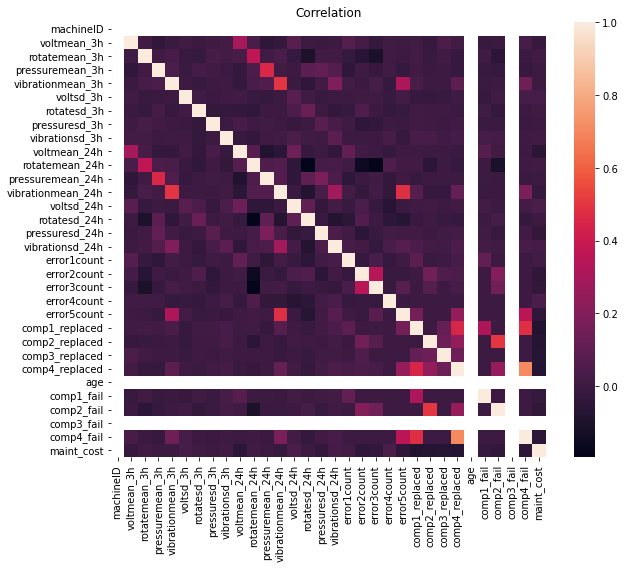

In [45]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df5.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            square=True, ax=ax)
plt.title("Correlation")
plt.show()

In [44]:
threshold_dates = [
    pd.to_datetime("2015-11-30 01:00:00"), pd.to_datetime("2015-12-01 01:00:00")
]

In [45]:
test_results = []
models = []
total = len(threshold_dates)

last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [46]:
ntraining = df5.loc[df5["datetime"] < last_train_date]
ntesting = df5.loc[df5["datetime"] > first_test_date]
print(f"{ntraining.shape[0]} Training records.")
print(f"{ntesting.shape[0]} Testing records.")
print(f"{ntesting.shape[0] / ntraining.shape[0] * 100:0.1f}% used for testing.")

2656 Training records.
251 Testing records.
9.5% used for testing.


In [51]:
# fails_train = ntraining[ntraining["failure"] != "none"].shape[0]
# no_fails_train = ntraining[ntraining["failure"] == "none"].shape[0]
# fails_test = ntesting[ntesting["failure"] != "none"].shape[0]
# no_fails_test = ntesting[ntesting["failure"] == "none"].shape[0]

# print(f"{fails_train / no_fails_train * 100:0.1f}% cases are failures in training.")
# print(f"{fails_test / no_fails_test * 100:0.1f}% cases are failures in testing.")

In [47]:
# Assigning values
train_y = df5.loc[df5["datetime"] < last_train_date, "failure"]
train_X = df5.loc[df5["datetime"] < last_train_date].drop(["datetime","machineID","model","failure"], axis=1)
test_y = df5.loc[df5["datetime"] > first_test_date, "failure"]
test_X = df5.loc[df5["datetime"] > first_test_date].drop(["datetime","machineID","model","failure"], axis=1)

In [56]:
train_y

0       0
1       0
2       0
3       0
4       0
       ..
2650    0
2651    0
2652    0
2653    0
2654    0
Name: failure, Length: 2655, dtype: int64

In [48]:
model = xgb()
model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [49]:
from sklearn.tree import DecisionTreeClassifier
clf =  DecisionTreeClassifier(criterion='entropy', random_state=0)  

In [50]:
clf.fit(train_X,train_y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [51]:
# X_test=test_X.tail(100)
predict = model.predict(test_X)
predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
predicted = clf.predict(test_X)
predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y,predicted)

0.9721115537848606

In [54]:
accuracy_score(test_y,predict)

0.9721115537848606

In [114]:
pd.set_option('display.max_columns',None)
test_X.loc[test_X['comp1_fail'] == 1]

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1count,error2count,error3count,error4count,error5count,comp1_replaced,comp2_replaced,comp3_replaced,comp4_replaced,age,comp1_fail,comp2_fail,comp3_fail,comp4_fail,maint_cost
2898,184.012579,485.497909,99.073268,39.613513,22.29516,39.741239,2.954681,3.229094,190.800618,460.785623,96.959409,40.339401,16.679409,51.55395,9.907534,3.270067,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14,1.0,0.0,0.0,0.0,15


In [55]:
test = df5.loc[df5["datetime"] > first_test_date].drop(["failure"], axis=1)

In [56]:
test['failure_status'] = predict

In [57]:
test.set_index(['datetime','machineID'],inplace=True)

In [58]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 64.3 MB/s eta 0:00:00


In [59]:
from pulp import *

In [60]:
list_of_machines = []

df = df.loc[df['comp1_replaced']==1|df['comp2_replaced']==1|df['comp3_replaced']==1|df['comp4_replaced']==1|]
df['machineID'].to_list()

SyntaxError: ignored

In [62]:
use_date = pulp.LpVariable.dicts("use_date",
                              ((datetime,machineID) for datetime,machineID in test.index),
                              lowBound=1,
                              cat='Integer')

In [ ]:
use_date

In [64]:
cost = pulp.LpVariable.dicts("cost",
                              ((datetime,machineID) for datetime,machineID in test.index),
                              lowBound=1,
                              cat='Integer')

In [65]:
cost

{(Timestamp('2015-12-01 03:00:00'),
  88): cost_(Timestamp('2015_12_01_03:00:00'),_88),
 (Timestamp('2015-12-01 06:00:00'),
  88): cost_(Timestamp('2015_12_01_06:00:00'),_88),
 (Timestamp('2015-12-01 09:00:00'),
  88): cost_(Timestamp('2015_12_01_09:00:00'),_88),
 (Timestamp('2015-12-01 12:00:00'),
  88): cost_(Timestamp('2015_12_01_12:00:00'),_88),
 (Timestamp('2015-12-01 15:00:00'),
  88): cost_(Timestamp('2015_12_01_15:00:00'),_88),
 (Timestamp('2015-12-01 18:00:00'),
  88): cost_(Timestamp('2015_12_01_18:00:00'),_88),
 (Timestamp('2015-12-01 21:00:00'),
  88): cost_(Timestamp('2015_12_01_21:00:00'),_88),
 (Timestamp('2015-12-02 00:00:00'),
  88): cost_(Timestamp('2015_12_02_00:00:00'),_88),
 (Timestamp('2015-12-02 03:00:00'),
  88): cost_(Timestamp('2015_12_02_03:00:00'),_88),
 (Timestamp('2015-12-02 06:00:00'),
  88): cost_(Timestamp('2015_12_02_06:00:00'),_88),
 (Timestamp('2015-12-02 09:00:00'),
  88): cost_(Timestamp('2015_12_02_09:00:00'),_88),
 (Timestamp('2015-12-02 12:00:00

In [67]:
# 1. Initialize Class
model = LpProblem("Cost minimising scheduling problem",LpMinimize)


In [68]:
model += pulp.lpSum(
    [cost[(datetime,machineID)] * test.loc[(datetime,machineID), 'maint_cost'] for datetime,machineID in test.index]
  )

In [69]:
model

Cost_minimising_scheduling_problem:
MINIMIZE
100*cost_(Timestamp('2015_12_01_03:00:00'),_88) + 100*cost_(Timestamp('2015_12_01_06:00:00'),_88) + 100*cost_(Timestamp('2015_12_01_09:00:00'),_88) + 100*cost_(Timestamp('2015_12_01_12:00:00'),_88) + 100*cost_(Timestamp('2015_12_01_15:00:00'),_88) + 100*cost_(Timestamp('2015_12_01_18:00:00'),_88) + 100*cost_(Timestamp('2015_12_01_21:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_00:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_03:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_06:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_09:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_12:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_15:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_18:00:00'),_88) + 100*cost_(Timestamp('2015_12_02_21:00:00'),_88) + 100*cost_(Timestamp('2015_12_03_00:00:00'),_88) + 100*cost_(Timestamp('2015_12_03_03:00:00'),_88) + 100*cost_(Timestamp('2015_12_03_06:00:00'),_88) + 100*cost_(Timestamp('2015_12_03_09:00:00'),_88) + 100*c

In [70]:
#constraints
model += cost[(datetime,machineID)] <= 30
model += cost[(datetime,machineID)] >0

NameError: ignored

In [71]:
model.solve()
LpStatus[model.status]

'Optimal'

In [72]:
output = []
for datetime,machineID in cost:
    var_output = {
        'datetime': datetime,
        'Machine': machineID,
        'Maintenance':cost[(datetime,machineID)].varValue
    }
    output.append(var_output)
output_df = pd.DataFrame.from_records(output).sort_values(['datetime'])
output_df.set_index(['datetime'], inplace=True)
output_df['Maintenance'].head()

datetime
2015-12-01 03:00:00    1.0
2015-12-01 06:00:00    1.0
2015-12-01 09:00:00    1.0
2015-12-01 12:00:00    1.0
2015-12-01 15:00:00    1.0
Name: Maintenance, dtype: float64

In [76]:
output_df[output_df['Maintenance'] > 1]

,Machine,Maintenance
datetime,,


In [ ]:
y

{0: quater_inv__0, 1: quater_inv__1, 2: quater_inv__2, 3: quater_inv__3}

In [ ]:
# 3. Define Objective
model += lpSum([prod_cost[i]*x[i] for i in quaters]) + lpSum([inv_cost[i]*y[i] for i in quaters])

In [ ]:
lpSum([prod_cost[i]*x[i] for i in quaters]) + lpSum([inv_cost[i]*y[i] for i in quaters])

250*quater_inv__0 + 250*quater_inv__1 + 250*quater_inv__2 + 250*quater_inv__3 + 3000*quater_prod__0 + 3300*quater_prod__1 + 3600*quater_prod__2 + 3600*quater_prod__3 + 0

In [ ]:
# Define Constraints
# Production-capacity constraints
for i in quaters:
    model.addConstraint(x[i]<=3000)



In [ ]:
# Inventory-balance constraints
model.addConstraint(x[0] - y[0] == demand[0]) # (Month 1)



In [ ]:
for i in quaters[1:]:
    model.addConstraint(x[i] - y[i] + y[i-1] == demand[i]) # for (Month 2, 3, 4) 

In [ ]:
model.solve()



1

In [ ]:
# Print the variables optimized value
for v in model.variables():
    print(v.name, "=", v.varValue)
    


__dummy = None
quater_inv__0 = 700.0
quater_inv__1 = 1700.0
quater_inv__2 = 1600.0
quater_inv__3 = 0.0
quater_prod__0 = 3000.0
quater_prod__1 = 3000.0
quater_prod__2 = 3000.0
quater_prod__3 = 1400.0


In [ ]:
# The optimised objective function value is printed to the screen
print("Value of Objective Function = ", value(model.objective))

AttributeError: ignored